In [8]:
# Import necessary libraries

import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam
import string
import nltk
import numpy as np

In [21]:
# Load the dataset

data = pd.read_csv("/content/judge-1377884607_tweet_product_company.csv",
                       encoding='unicode_escape')
data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [23]:
# Create a working dataframe with easier column name


data.drop_duplicates(subset=['tweet_text'], inplace=True)
data.dropna(subset=['tweet_text'], inplace=True)
data.rename(columns = {'emotion_in_tweet_is_directed_at':'item', 'is_there_an_emotion_directed_at_a_brand_or_product':'emotion'}, inplace=True)


In [24]:

# Convert the data types to string
data['tweet_text'] = data['tweet_text'].astype(str)
data['item'] = data['item'].astype(str)

In [26]:
#Unique values of items column


data['item'].unique()

array(['iPhone', 'iPad or iPhone App', 'iPad', 'Google', 'nan', 'Android',
       'Apple', 'Android App', 'Other Google product or service',
       'Other Apple product or service'], dtype=object)

In [27]:
# Brand name mapping


brand = {'iPhone': 'Apple',
         'iPad or iPhone App':'Apple',
         'iPad': 'Apple',
         'Google': 'Google',
         'nan': 'Others',
         'Android':'Google',
         'Apple': 'Apple',
         'Android App':'Google',
         'Other Google product or service':'Google',
         'Other Apple product or service':'Apple'
        }

data['item'] = data['item'].map(brand)

# Encoding class label to brief
label_encoder = {'Negative emotion': 'Cons',
                 'Positive emotion': 'Pros',
                 'No emotion toward brand or product': 'Neutral',
                 "I can't tell":'Unknown'}

data['emotion'] = data['emotion'].map(label_encoder)

In [28]:
#viewing dataset
data.head()

,tweet_text,item,emotion
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",Apple,Cons
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",Apple,Pros
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,Apple,Pros
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,Apple,Cons
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Pros


<ipython-input-30-549e63d739a8>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='emotion',


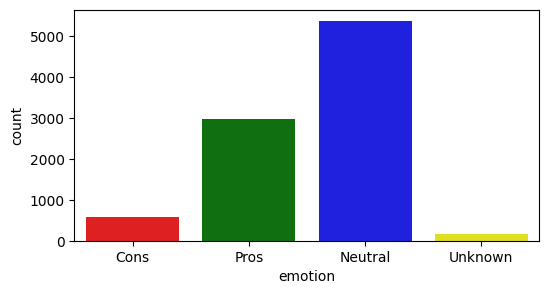

In [30]:
#Countplot for emotion column

import matplotlib.pyplot as plt
import seaborn as sns

fig =  plt.figure(figsize=(6,3))
sns.countplot(x='emotion',
              data=data,
              palette=['Red', 'Green', 'Blue', 'Yellow'])
plt.show()

<ipython-input-34-e796a2d310a7>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='item', data=data,


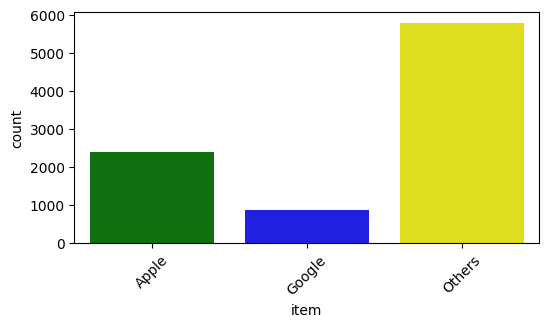

In [34]:
#Count plot for items

#fig =  plt.figure(figsize=(6,3))
#sns.countplot(x='item', data=data)
#plt.xticks(rotation=60);

fig =  plt.figure(figsize=(6,3))
sns.countplot(x='item', data=data,
              palette=['green', 'blue', 'yellow'])
plt.xticks(rotation=45);

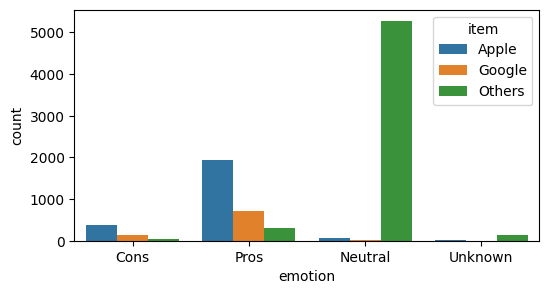

In [36]:
plt.figure(figsize=(6,3))
ax = sns.countplot(data = data, x = 'emotion', hue='item')

In [37]:
df = data[['emotion', 'tweet_text']]
df.head()

,emotion,tweet_text
0,Cons,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW."
1,Pros,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW"
2,Pros,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.
3,Cons,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw
4,Pros,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)"


In [38]:
pd.set_option('display.max_colwidth', None)
df.head()

,emotion,tweet_text
0,Cons,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW."
1,Pros,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW"
2,Pros,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.
3,Cons,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw
4,Pros,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)"


In [40]:
#Data Preprocessing

#importing string library

import string

#function to remove punctuations

def remove_punctuation(text):
  punctuationfree=' '
  punctuationfree="".join([i for i in text if i not in string.punctuation])
  return punctuationfree

#adding punctuationfree column to the dataset

df['clean_msg']=df['tweet_text'].apply(lambda x:remove_punctuation(x))
df.head()

,emotion,tweet_text,clean_msg
0,Cons,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",wesley83 I have a 3G iPhone After 3 hrs tweeting at RISEAustin it was dead I need to upgrade Plugin stations at SXSW
1,Pros,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",jessedee Know about fludapp Awesome iPadiPhone app that youll likely appreciate for its design Also theyre giving free Ts at SXSW
2,Pros,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,swonderlin Can not wait for iPad 2 also They should sale them down at SXSW
3,Cons,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,sxsw I hope this years festival isnt as crashy as this years iPhone app sxsw
4,Pros,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",sxtxstate great stuff on Fri SXSW Marissa Mayer Google Tim OReilly tech booksconferences amp Matt Mullenweg Wordpress


In [41]:
#Word tokenization

import nltk
nltk.download('punkt')
def tokenization(text):
  tokens=nltk.word_tokenize(text)
  return tokens
#adding tokenized column to dataset
df['tokenized_msg']=df['clean_msg'].apply(lambda x:tokenization(x))
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,emotion,tweet_text,clean_msg,tokenized_msg
0,Cons,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",wesley83 I have a 3G iPhone After 3 hrs tweeting at RISEAustin it was dead I need to upgrade Plugin stations at SXSW,"[wesley83, I, have, a, 3G, iPhone, After, 3, hrs, tweeting, at, RISEAustin, it, was, dead, I, need, to, upgrade, Plugin, stations, at, SXSW]"
1,Pros,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",jessedee Know about fludapp Awesome iPadiPhone app that youll likely appreciate for its design Also theyre giving free Ts at SXSW,"[jessedee, Know, about, fludapp, Awesome, iPadiPhone, app, that, youll, likely, appreciate, for, its, design, Also, theyre, giving, free, Ts, at, SXSW]"
2,Pros,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,swonderlin Can not wait for iPad 2 also They should sale them down at SXSW,"[swonderlin, Can, not, wait, for, iPad, 2, also, They, should, sale, them, down, at, SXSW]"
3,Cons,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,sxsw I hope this years festival isnt as crashy as this years iPhone app sxsw,"[sxsw, I, hope, this, years, festival, isnt, as, crashy, as, this, years, iPhone, app, sxsw]"
4,Pros,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",sxtxstate great stuff on Fri SXSW Marissa Mayer Google Tim OReilly tech booksconferences amp Matt Mullenweg Wordpress,"[sxtxstate, great, stuff, on, Fri, SXSW, Marissa, Mayer, Google, Tim, OReilly, tech, booksconferences, amp, Matt, Mullenweg, Wordpress]"


In [42]:
#Function to remove stopwords

nltk.download('stopwords')
stopwords=nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
  output= [i for i in text if i not in stopwords]
  return output

#adding stopwords removed column to dataset


df['remove_stopwords']=df['tokenized_msg'].apply(lambda x:remove_stopwords(x))
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,emotion,tweet_text,clean_msg,tokenized_msg,remove_stopwords
0,Cons,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",wesley83 I have a 3G iPhone After 3 hrs tweeting at RISEAustin it was dead I need to upgrade Plugin stations at SXSW,"[wesley83, I, have, a, 3G, iPhone, After, 3, hrs, tweeting, at, RISEAustin, it, was, dead, I, need, to, upgrade, Plugin, stations, at, SXSW]","[wesley83, I, 3G, iPhone, After, 3, hrs, tweeting, RISEAustin, dead, I, need, upgrade, Plugin, stations, SXSW]"
1,Pros,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",jessedee Know about fludapp Awesome iPadiPhone app that youll likely appreciate for its design Also theyre giving free Ts at SXSW,"[jessedee, Know, about, fludapp, Awesome, iPadiPhone, app, that, youll, likely, appreciate, for, its, design, Also, theyre, giving, free, Ts, at, SXSW]","[jessedee, Know, fludapp, Awesome, iPadiPhone, app, youll, likely, appreciate, design, Also, theyre, giving, free, Ts, SXSW]"
2,Pros,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,swonderlin Can not wait for iPad 2 also They should sale them down at SXSW,"[swonderlin, Can, not, wait, for, iPad, 2, also, They, should, sale, them, down, at, SXSW]","[swonderlin, Can, wait, iPad, 2, also, They, sale, SXSW]"
3,Cons,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,sxsw I hope this years festival isnt as crashy as this years iPhone app sxsw,"[sxsw, I, hope, this, years, festival, isnt, as, crashy, as, this, years, iPhone, app, sxsw]","[sxsw, I, hope, years, festival, isnt, crashy, years, iPhone, app, sxsw]"
4,Pros,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",sxtxstate great stuff on Fri SXSW Marissa Mayer Google Tim OReilly tech booksconferences amp Matt Mullenweg Wordpress,"[sxtxstate, great, stuff, on, Fri, SXSW, Marissa, Mayer, Google, Tim, OReilly, tech, booksconferences, amp, Matt, Mullenweg, Wordpress]","[sxtxstate, great, stuff, Fri, SXSW, Marissa, Mayer, Google, Tim, OReilly, tech, booksconferences, amp, Matt, Mullenweg, Wordpress]"


In [43]:
#Function for lemmatization

from nltk.stem import WordNetLemmatizer # Capitalize 'W' in 'WordNetLemmatizer'
nltk.download('wordnet')
wordnet_lemmatizer=WordNetLemmatizer()
def lemmatizer(text):
  lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
  return lemm_text

#adding lemmatized column to dataset

df['lemmatized_tweet']=df['remove_stopwords'].apply(lambda x:lemmatizer(x))
df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...


,emotion,tweet_text,clean_msg,tokenized_msg,remove_stopwords,lemmatized_tweet
0,Cons,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",wesley83 I have a 3G iPhone After 3 hrs tweeting at RISEAustin it was dead I need to upgrade Plugin stations at SXSW,"[wesley83, I, have, a, 3G, iPhone, After, 3, hrs, tweeting, at, RISEAustin, it, was, dead, I, need, to, upgrade, Plugin, stations, at, SXSW]","[wesley83, I, 3G, iPhone, After, 3, hrs, tweeting, RISEAustin, dead, I, need, upgrade, Plugin, stations, SXSW]","[wesley83, I, 3G, iPhone, After, 3, hr, tweeting, RISEAustin, dead, I, need, upgrade, Plugin, station, SXSW]"
1,Pros,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",jessedee Know about fludapp Awesome iPadiPhone app that youll likely appreciate for its design Also theyre giving free Ts at SXSW,"[jessedee, Know, about, fludapp, Awesome, iPadiPhone, app, that, youll, likely, appreciate, for, its, design, Also, theyre, giving, free, Ts, at, SXSW]","[jessedee, Know, fludapp, Awesome, iPadiPhone, app, youll, likely, appreciate, design, Also, theyre, giving, free, Ts, SXSW]","[jessedee, Know, fludapp, Awesome, iPadiPhone, app, youll, likely, appreciate, design, Also, theyre, giving, free, Ts, SXSW]"
2,Pros,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,swonderlin Can not wait for iPad 2 also They should sale them down at SXSW,"[swonderlin, Can, not, wait, for, iPad, 2, also, They, should, sale, them, down, at, SXSW]","[swonderlin, Can, wait, iPad, 2, also, They, sale, SXSW]","[swonderlin, Can, wait, iPad, 2, also, They, sale, SXSW]"
3,Cons,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,sxsw I hope this years festival isnt as crashy as this years iPhone app sxsw,"[sxsw, I, hope, this, years, festival, isnt, as, crashy, as, this, years, iPhone, app, sxsw]","[sxsw, I, hope, years, festival, isnt, crashy, years, iPhone, app, sxsw]","[sxsw, I, hope, year, festival, isnt, crashy, year, iPhone, app, sxsw]"
4,Pros,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",sxtxstate great stuff on Fri SXSW Marissa Mayer Google Tim OReilly tech booksconferences amp Matt Mullenweg Wordpress,"[sxtxstate, great, stuff, on, Fri, SXSW, Marissa, Mayer, Google, Tim, OReilly, tech, booksconferences, amp, Matt, Mullenweg, Wordpress]","[sxtxstate, great, stuff, Fri, SXSW, Marissa, Mayer, Google, Tim, OReilly, tech, booksconferences, amp, Matt, Mullenweg, Wordpress]","[sxtxstate, great, stuff, Fri, SXSW, Marissa, Mayer, Google, Tim, OReilly, tech, booksconferences, amp, Matt, Mullenweg, Wordpress]"


In [44]:
#Vectorization

from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(ngram_range=(1,2))


#splitting data as x and y

# Join the lemmatized tokens back into strings
df['final_string'] = df['lemmatized_tweet'].apply(' '.join)

X = df['final_string']

In [50]:
y = pd.get_dummies(df['emotion'])

In [51]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)


In [52]:
from tensorflow.keras.preprocessing import sequence
from sklearn.feature_extraction.text import CountVectorizer

# Assuming 'X_train' is  training data as a Pandas Series
cv = CountVectorizer(ngram_range=(1,2))
X_train_vec = cv.fit_transform(X_train)  # Convert text to numerical vectors
X_test_vec = cv.transform(X_test)  # Convert text to numerical vectors

# Now pad the sequences
X_train_padded = sequence.pad_sequences(X_train_vec.toarray(), maxlen=300)
X_test_padded = sequence.pad_sequences(X_test_vec.toarray(), maxlen=300)

In [53]:
X_train_padded.shape

(6798, 300)

In [54]:
y_train

,Cons,Neutral,Pros,Unknown
9014,False,True,False,False
1706,False,True,False,False
4484,False,False,True,False
7176,False,False,False,True
493,False,True,False,False
...,...,...,...,...
5746,False,False,True,False
5201,False,True,False,False
5402,False,True,False,False
863,False,True,False,False


In [55]:
#Libraries---> RNN

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN

In [57]:
model= Sequential()
model.add(Embedding(input_dim=20000,output_dim=150,input_length=300))
model.add(SimpleRNN(128,dropout=0.2))
model.add(Dense(4, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 150)          3000000   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               35712     
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 3036228 (11.58 MB)
Trainable params: 3036228 (11.58 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [58]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [59]:
model.fit(X_train_padded,y_train,epochs=4,batch_size=256)

Epoch 1/4
27/27 [==============================] - 12s 324ms/step - loss: 0.9748 - accuracy: 0.5583
Epoch 2/4
27/27 [==============================] - 8s 317ms/step - loss: 0.9269 - accuracy: 0.5888
Epoch 3/4
27/27 [==============================] - 8s 270ms/step - loss: 0.9259 - accuracy: 0.5888
Epoch 4/4
27/27 [==============================] - 9s 324ms/step - loss: 0.9287 - accuracy: 0.5888


In [60]:
model.evaluate(X_test_padded,y_test)

71/71 [==============================] - 2s 22ms/step - loss: 0.9076 - accuracy: 0.6039


[0.9076249003410339, 0.6038817763328552]

In [72]:
#Libraries --->LSTM

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding, GlobalMaxPool1D, Dropout, Dense


In [76]:
model2= Sequential()
model2.add(Embedding(input_dim=1000,output_dim=150,input_length=300))
model2.add(GlobalMaxPool1D())
model2.add(Dropout(0.2))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(4, activation='softmax'))
model2.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 300, 150)          150000    
                                                                 
 global_max_pooling1d_5 (Gl  (None, 150)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_3 (Dropout)         (None, 150)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                9664      
                                                                 
 dense_7 (Dense)             (None, 4)                 260       
                                                                 
Total params: 159924 (624.70 KB)
Trainable params: 159924 (624.70 KB)
Non-trainable params: 0 (0.00 Byte)
_____________

In [77]:
model2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [79]:
model2.fit(X_train_padded,y_train,epochs=4,batch_size=256)

Epoch 1/4
27/27 [==============================] - 0s 9ms/step - loss: 0.9249 - accuracy: 0.5888
Epoch 2/4
27/27 [==============================] - 0s 7ms/step - loss: 0.9241 - accuracy: 0.5888
Epoch 3/4
27/27 [==============================] - 0s 6ms/step - loss: 0.9257 - accuracy: 0.5888
Epoch 4/4
27/27 [==============================] - 0s 6ms/step - loss: 0.9264 - accuracy: 0.5888


In [80]:
model2.evaluate(X_test_padded,y_test)

71/71 [==============================] - 0s 2ms/step - loss: 0.9070 - accuracy: 0.6039


[0.907031774520874, 0.6038817763328552]

In [82]:
#Library ---> GRU


from tensorflow.keras.layers import GRU
model3= Sequential()
model3.add(Embedding(input_dim=20000,output_dim=150,input_length=300))
model3.add(GlobalMaxPool1D())
model3.add(Dropout(0.2))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(4, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 150)          3000000   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               35712     
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 3036228 (11.58 MB)
Trainable params: 3036228 (11.58 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [83]:
model3.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [84]:
model3.fit(X_train_padded,y_train,epochs=4,batch_size=256)

Epoch 1/4
27/27 [==============================] - 1s 13ms/step - loss: 1.2158 - accuracy: 0.5530
Epoch 2/4
27/27 [==============================] - 0s 8ms/step - loss: 0.9471 - accuracy: 0.5888
Epoch 3/4
27/27 [==============================] - 0s 7ms/step - loss: 0.9280 - accuracy: 0.5888
Epoch 4/4
27/27 [==============================] - 0s 7ms/step - loss: 0.9255 - accuracy: 0.5888


In [85]:
model3.evaluate(X_test_padded,y_test)

71/71 [==============================] - 0s 2ms/step - loss: 0.9050 - accuracy: 0.6039


[0.9049689769744873, 0.6038817763328552]

In [86]:
#Libraries --->CNN 1D


from tensorflow.keras.layers import Conv1D,Dropout,GlobalMaxPooling1D
model4= Sequential()
model4.add(Embedding(input_dim=20000,output_dim=150,input_length=300))
model4.add(Conv1D(64,kernel_size=5,padding="same",activation='relu')) # Fixed typo: kernal_size to kernel_size
model4.add(Dropout(0.2))
model4.add(Conv1D(64,kernel_size=5,padding="same",activation='relu')) # Fixed typo: kernal_size to kernel_size
model4.add(Dropout(0.2))
model4.add(GlobalMaxPooling1D())
model4.add(Dense(128,activation='relu'))
model4.add(Dense(4, activation='softmax'))
model4.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 300, 150)          3000000   
                                                                 
 conv1d (Conv1D)             (None, 300, 64)           48064     
                                                                 
 dropout_5 (Dropout)         (None, 300, 64)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 300, 64)           20544     
                                                                 
 dropout_6 (Dropout)         (None, 300, 64)           0         
                                                                 
 global_max_pooling1d_7 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                     

In [87]:
model4.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [88]:
model4.fit(X_train_padded,y_train,epochs=4,batch_size=256)

Epoch 1/4
27/27 [==============================] - 4s 32ms/step - loss: 1.0227 - accuracy: 0.5662
Epoch 2/4
27/27 [==============================] - 1s 20ms/step - loss: 0.9269 - accuracy: 0.5888
Epoch 3/4
27/27 [==============================] - 1s 20ms/step - loss: 0.9251 - accuracy: 0.5888
Epoch 4/4
27/27 [==============================] - 1s 20ms/step - loss: 0.9250 - accuracy: 0.5888


In [89]:
model4.evaluate(X_test_padded,y_test)

71/71 [==============================] - 1s 4ms/step - loss: 0.9953 - accuracy: 0.6039


[0.9953321218490601, 0.6038817763328552]

In [90]:
#Using RandomForestClassifier


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


clf = RandomForestClassifier()
clf.fit(X_train_padded,y_train)

RandomForestClassifier()

In [91]:
from sklearn import metrics
y_pred=clf.predict(X_test_padded)
print("Accuracy:",metrics.accuracy_score(y_pred,y_test))

Accuracy: 0.6047640052933392
